Year: 2000
Silhouette score for 2 clusters: 0.6572770861471439
Silhouette score for 3 clusters: 0.5534574804933347
Silhouette score for 4 clusters: 0.5506980753231844
Silhouette score for 5 clusters: 0.5345037066200591
Silhouette score for 6 clusters: 0.4872737836036058
Silhouette score for 7 clusters: 0.5020691265595301
Silhouette score for 8 clusters: 0.5134857757998427
Silhouette score for 9 clusters: 0.5322475906826886
Silhouette score for 10 clusters: 0.5268069130201158


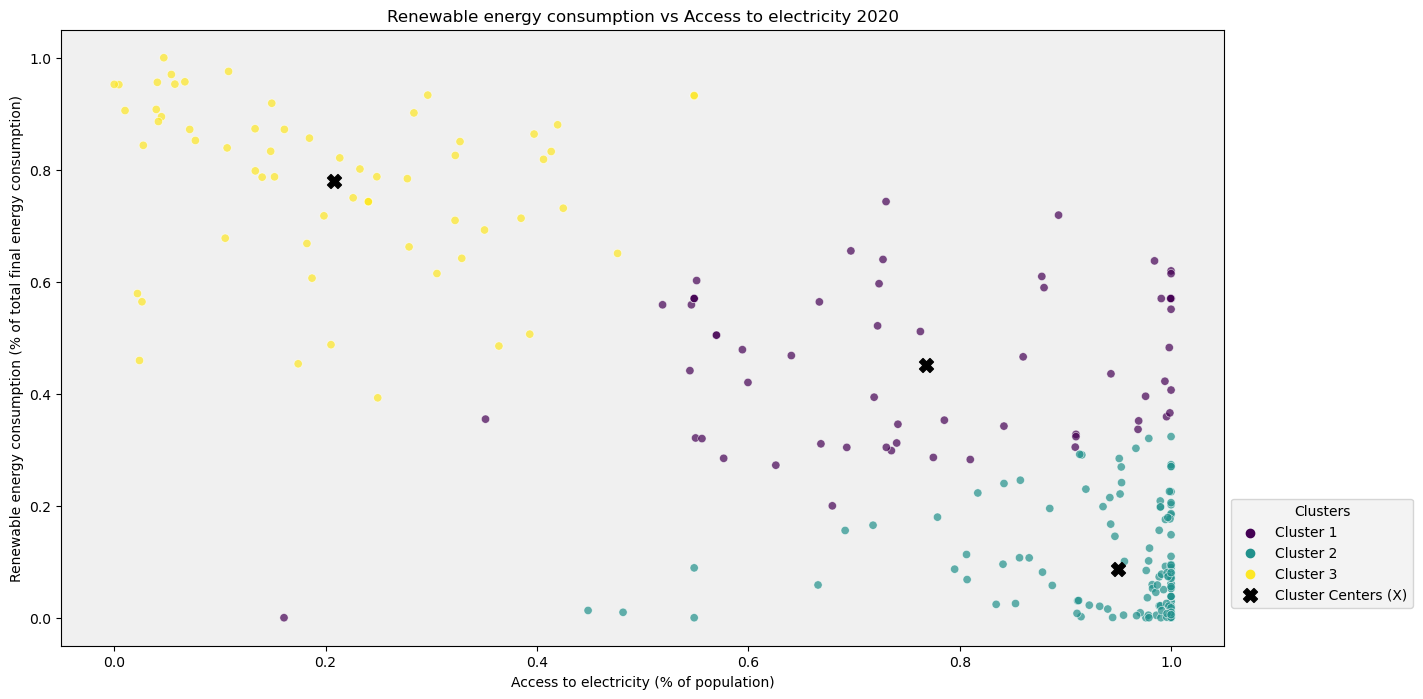

Year: 2020
Silhouette score for 2 clusters: 0.661649883943328
Silhouette score for 3 clusters: 0.552303524380538
Silhouette score for 4 clusters: 0.5687735489046228
Silhouette score for 5 clusters: 0.5032649084287649
Silhouette score for 6 clusters: 0.489816512141287
Silhouette score for 7 clusters: 0.487196327032569
Silhouette score for 8 clusters: 0.47184104832872675
Silhouette score for 9 clusters: 0.44627136050789973
Silhouette score for 10 clusters: 0.4795606423779097


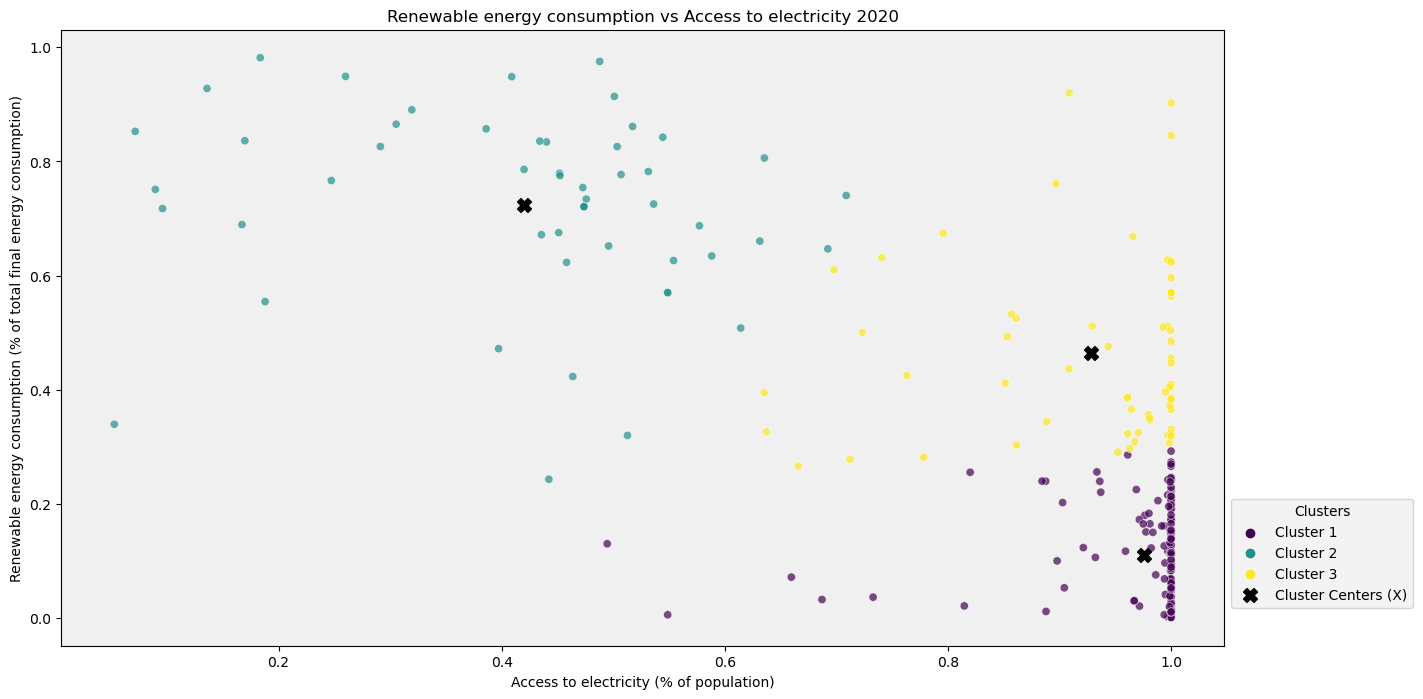

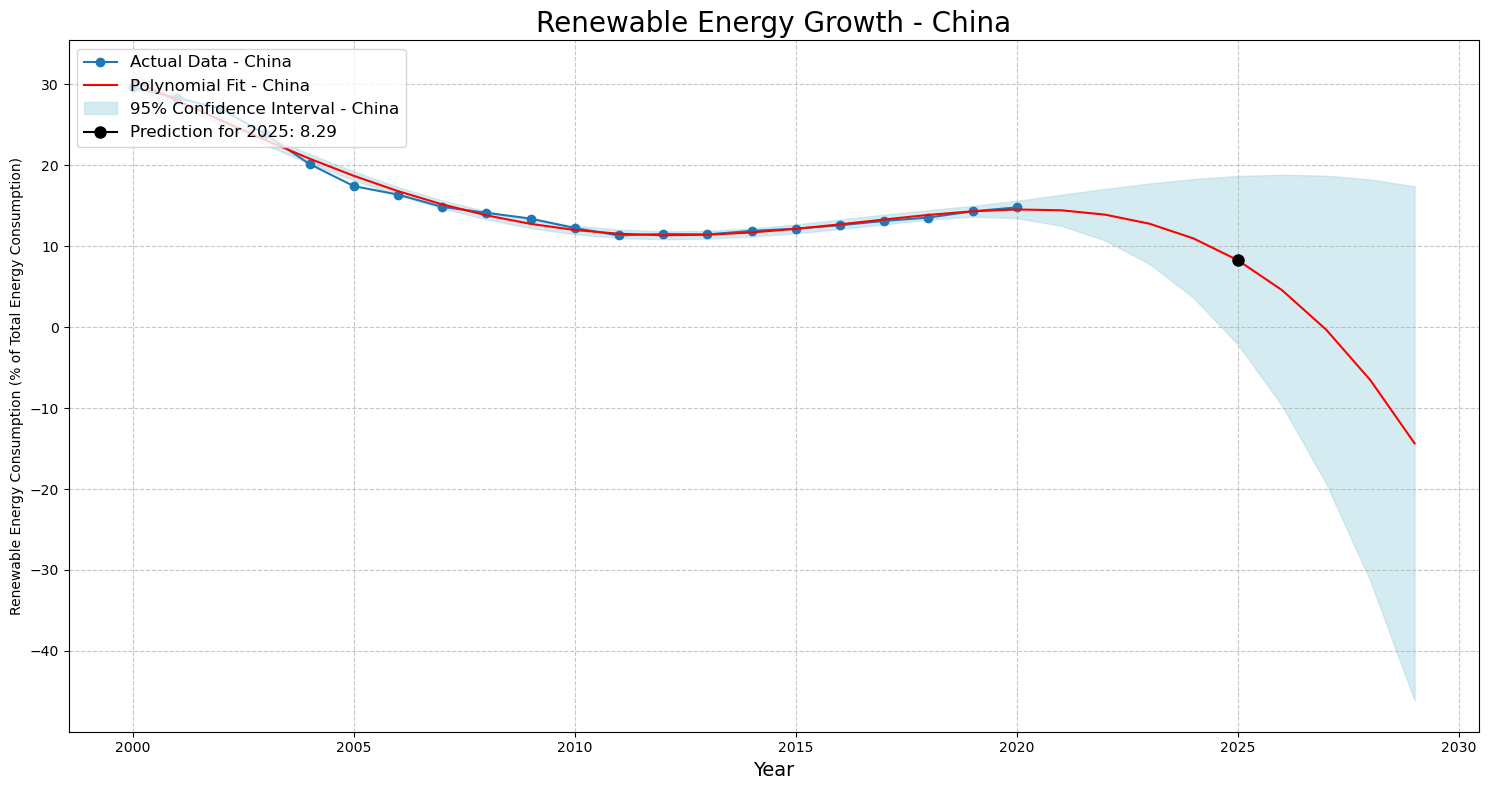

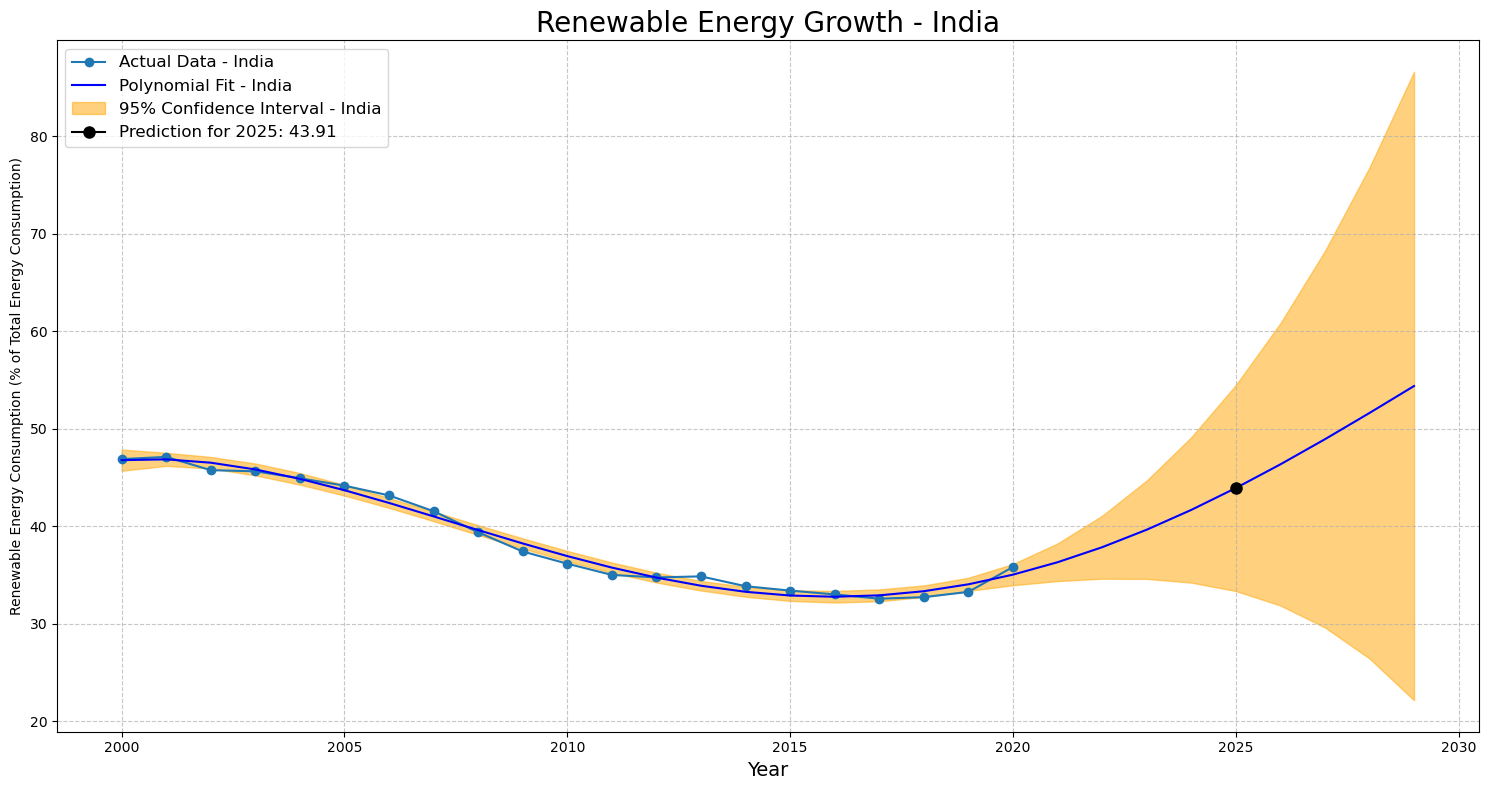

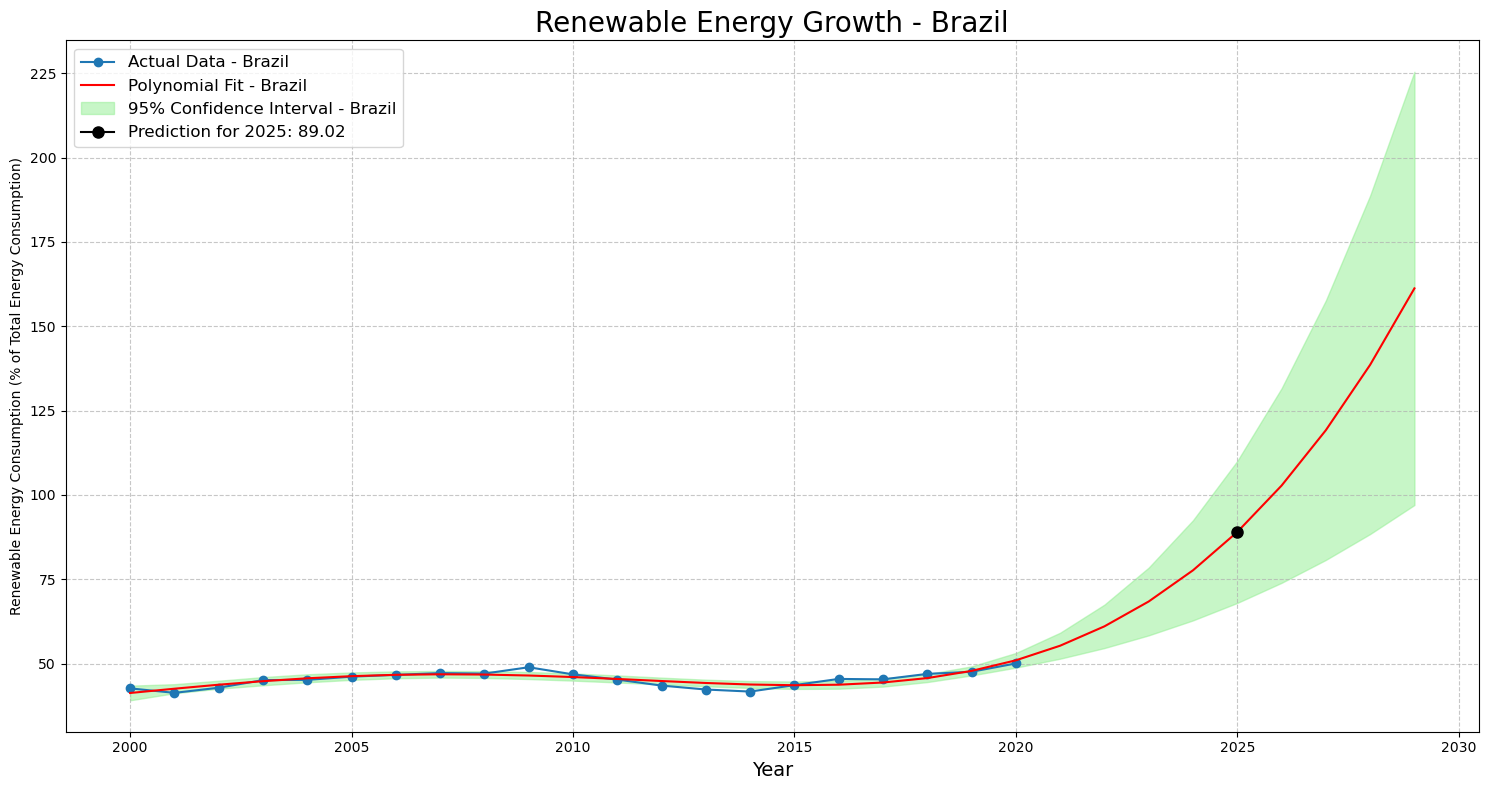

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import seaborn as sns
import numpy as np
import scipy.optimize as opt

def load_dataset(file_path):
    return pd.read_excel(file_path)

def filter_selected_indicators(data, selected_indicators, years_of_interest):
    filtered_data = data[data["Indicator Name"].isin(selected_indicators)]
    return pd.melt(filtered_data, id_vars=["Country Name", "Indicator Name"], 
                   value_vars=years_of_interest, var_name="Year", value_name="Value")

def impute_missing_values(data_melted):
    imputer = SimpleImputer(strategy='mean')
    data_melted['Value'] = imputer.fit_transform(data_melted[['Value']])
    return data_melted

def pivot_and_scale_data(data_melted, selected_indicators):
    data_pivoted = data_melted.pivot_table(index=["Country Name", "Year"], 
                                           columns="Indicator Name", values="Value").reset_index()
    
    min_max_scaler = MinMaxScaler()
    normalized_data = data_pivoted.copy()
    normalized_data[selected_indicators] = min_max_scaler.fit_transform(data_pivoted[selected_indicators])
    
    return normalized_data, min_max_scaler

def kmeans_clustering_and_plotting(normalized_data, selected_indicators, years_of_interest):
    for year in years_of_interest:
        year_data = normalized_data[normalized_data['Year'] == year].copy()

        print(f"Year: {year}")
        for n_clusters in range(2, 11):
            kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
            kmeans.fit(year_data[selected_indicators])
            silhouette_avg = silhouette_score(year_data[selected_indicators], kmeans.labels_)
            print(f"Silhouette score for {n_clusters} clusters: {silhouette_avg}")

        kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
        kmeans.fit(year_data[selected_indicators])

        year_data['Cluster'] = kmeans.labels_


        plot_cluster_results(year_data, selected_indicators, kmeans)

def plot_cluster_results(year_data, selected_indicators, kmeans):
    plt.figure(figsize=(15, 8))
    face_color = '#f0f0f0'
    plt.gca().set_facecolor(face_color)
    scatterplot = sns.scatterplot(data=year_data, x=selected_indicators[0], y=selected_indicators[1], hue='Cluster', palette='viridis', alpha=0.7)

    cluster_centers = kmeans.cluster_centers_
    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', s=100, color='black', label='Cluster Centers (X)')

    handles, labels = scatterplot.get_legend_handles_labels()
    legend_labels = [f'Cluster {i+1}' for i in range(len(set(kmeans.labels_)))]
    legend_labels.append('Cluster Centers (X)')

    legend = plt.legend(handles=handles + [plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='black', markersize=10)], 
               labels=legend_labels, title='Clusters', bbox_to_anchor=(1, .25), loc='upper left')

    legend.get_frame().set_facecolor(face_color)

    plt.title(f'Renewable energy consumption vs Access to electricity {year}')
    plt.xlabel(selected_indicators[0])
    plt.ylabel(selected_indicators[1])

    plt.show()

def reshape_data(data):
    data_reshaped = data.drop(['Indicator Name'], axis=1).set_index('Country Name').T
    data_reshaped.index = data_reshaped.index.astype(int)
    return data_reshaped

def polynomial_with_error(x, a, b, c, d, e):
    x = x - 2000
    return a + b * x + c * x**2 + d * x**3 + e * x**4

def confidence_interval(x, params, covar, func):
    pred = func(x, *params)
    J = np.array([[df(x, *params) for df in dfunc] for x in x])
    pred_se = np.sqrt(np.diag(J @ covar @ J.T))
    ci = 1.96 * pred_se
    return pred - ci, pred + ci

def fit_and_plot_polynomial(country_data, country, colors):
    country_colors = colors.get(country, {})
    line_color = country_colors.get('line', 'green')
    fill_color = country_colors.get('fill', 'lightgreen')

    param_poly, covar_poly = opt.curve_fit(
        polynomial_with_error, 
        country_data.index, 
        country_data.values,
        maxfev=10000
    )

    year_range = np.arange(2000, 2030)
    low_poly, up_poly = confidence_interval(year_range, param_poly, covar_poly, polynomial_with_error)

    prediction_2025 = polynomial_with_error(2025, *param_poly)

    plt.figure(figsize=(15, 8), facecolor='#ffffff')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.gca().set_facecolor('#ffffff')

    plt.plot(country_data.index, country_data, label=f"Actual Data - {country}", marker="o")
    plt.plot(year_range, polynomial_with_error(year_range, *param_poly), label=f"Polynomial Fit - {country}", color=line_color)
    plt.fill_between(year_range, low_poly, up_poly, color=fill_color, alpha=0.5, label=f"95% Confidence Interval - {country}")
    plt.plot(2025, prediction_2025, marker='o', markersize=8, label=f'Prediction for 2025: {prediction_2025:.2f}', color='black')

    plt.title(f"Renewable Energy Growth - {country}", fontsize=20)
    plt.xlabel("Year", fontsize=14)
    plt.ylabel("Renewable Energy Consumption (% of Total Energy Consumption)", fontsize=10)

    plt.legend(loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.show()

# Main code
file_path = "world_bank_data_New.xlsx"
data = load_dataset(file_path)

selected_indicators = [
    "Access to electricity (% of population)",
    "Renewable energy consumption (% of total final energy consumption)"
]

years_of_interest = [2000, 2020]

data_melted = filter_selected_indicators(data, selected_indicators, years_of_interest)
data_melted = impute_missing_values(data_melted)

data_pivoted, min_max_scaler = pivot_and_scale_data(data_melted, selected_indicators)

kmeans_clustering_and_plotting(data_pivoted, selected_indicators, years_of_interest)

Renewable_energy_growth_data = data[data['Indicator Name'] == 'Renewable energy consumption (% of total final energy consumption)']
Renewable_energy_growth_reshaped = reshape_data(Renewable_energy_growth_data)

sample_countries = ['China', 'India', 'Brazil']

colors = {
    'China': {'line': 'red', 'fill': 'lightblue', 'interval': 'yellow'},
    'India': {'line': 'blue', 'fill': 'orange', 'interval': 'cyan'},
    'Brazil': {'line': 'red', 'fill': 'lightgreen', 'interval': 'mistyrose'}
}

for country in sample_countries:
    country_data = Renewable_energy_growth_reshaped[country].dropna()
    fit_and_plot_polynomial(country_data, country, colors)

    